In [2]:
import csv
import os

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Conv1D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf

# 1. Utworzenie zbioru treningowego i testowego

## 1.1 Otwarcie pliku

In [3]:
with open('data.csv', newline='') as f:
    reader = csv.reader(f)
    data_temp = list(reader)
data_temp.pop(0)
print(data_temp[:10])

[['0_109', '0', '109', '-1.1573821046220343', '0.0', 'False', 'False'], ['0_114', '0', '114', '-1.1573821046220343', '0.0', 'False', 'False'], ['0_124', '0', '124', '-1.1573821046220343', '0.0', 'False', 'False'], ['0_134', '0', '134', '-1.1573821046220343', '0.0', 'False', 'False'], ['0_139', '0', '139', '-1.1573821046220343', '0.0', 'False', 'False'], ['0_149', '0', '149', '-1.1573821046220343', '0.0', 'False', 'False'], ['0_174', '0', '174', '-1.0701058442104696', '0.013333333333333336', 'False', 'False'], ['0_199', '0', '199', '-1.0701058442104696', '0.013333333333333336', 'False', 'False'], ['0_204', '0', '204', '-0.9828295837989051', '0.026666666666666672', 'False', 'False'], ['0_219', '0', '219', '-0.9828295837989051', '0.026666666666666672', 'False', 'False']]


In [4]:
data = []
true = false = 0
for x in data_temp:
    if x[6] == 'True':
        true += 1
    else:
        false += 1
    data.append([x[0], float(x[3]), float(x[4]), x[5] == 'True', x[6] == 'True'])
print(data[0], true, false)

['0_109', -1.1573821046220343, 0.0, False, False] 8927 6706


## 1.2 Obliczenie rozmiaru

In [5]:
# train_count = int(len(data) * 0.8)
# test_count = len(data) - train_count
# print(train_count + test_count, len(data))
# assert train_count + test_count == len(data)

frame_size = 25

## 1.3 Utworzenie zbioru

Dla każdego Y dodawane jest do X frame_size wartości sensora przed

In [6]:
X_train_min_max = []
X_train_z_score = []
Y_train = []
X_test_min_max = []
X_test_z_score = []
Y_test = []

train_images = os.listdir('dataset/train/true')
train_images = [x.split('.')[0].split('_') for x in train_images]
train_images = [[int(x[0]), int(x[1])] for x in train_images]
test_images = os.listdir('dataset/test/true')
test_images = [x.split('.')[0].split('_') for x in test_images]
test_images = [[int(x[0]), int(x[1])] for x in test_images]

frame_length = 25 - 1
sensor_values_min_max = []
sensor_values_z_score = []


for i in range(len(data)):
    video_id = int(data[i][0].split('_')[0])
    frame_id = int(data[i][0].split('_')[1])
    ground_truth = data[i][4]

    # sensor_values_min_max = [data[j][2] for j in range(i - frame_length, i + 1)]
    # sensor_values_z_score = [data[j][1] for j in range(i - frame_length, i + 1)]
    # if [video_id, frame_id] in train_images:
    #     Y_train.append(ground_truth)
    #     X_train_min_max.append(sensor_values_min_max)
    #     X_train_z_score.append(sensor_values_z_score)
    # else:
    #     Y_test.append(ground_truth)
    #     X_test_min_max.append(sensor_values_min_max)
    #     X_test_z_score.append(sensor_values_z_score)

    if i % 25 == 0 and i != 0:
        if [video_id, frame_id] in train_images:
            Y_train.append(ground_truth)
            X_train_min_max.append(sensor_values_min_max)
            X_train_z_score.append(sensor_values_z_score)
        else:
            Y_test.append(ground_truth)
            X_test_min_max.append(sensor_values_min_max)
            X_test_z_score.append(sensor_values_z_score)
        sensor_values_min_max = []
        sensor_values_z_score = []

    sensor_values_min_max.append(data[i][2])
    sensor_values_z_score.append(data[i][1])

print(len(Y_train), len(Y_test))

X_train_min_max = np.array(X_train_min_max)
X_train_z_score = np.array(X_train_z_score)
Y_train = np.array(Y_train)
print(X_test_min_max[1])
X_test_min_max = np.array(X_test_min_max)
X_test_z_score = np.array(X_test_z_score)
Y_test = np.array(Y_test)

361 264
[0.12, 0.12, 0.13333333333333333, 0.18666666666666668, 0.25333333333333335, 0.26666666666666666, 0.25333333333333335, 0.19999999999999998, 0.16, 0.013333333333333336, 0.013333333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [7]:
data_np = np.array(data)

filter_false = data_np[:, 4] == 'True'
# data_true = data_np[filter_true][:,2]
# data_false = data_np[filter_false][:,2]
print(print(data_np[0]))

['0_109' '-1.1573821046220343' '0.0' 'False' 'False']
None


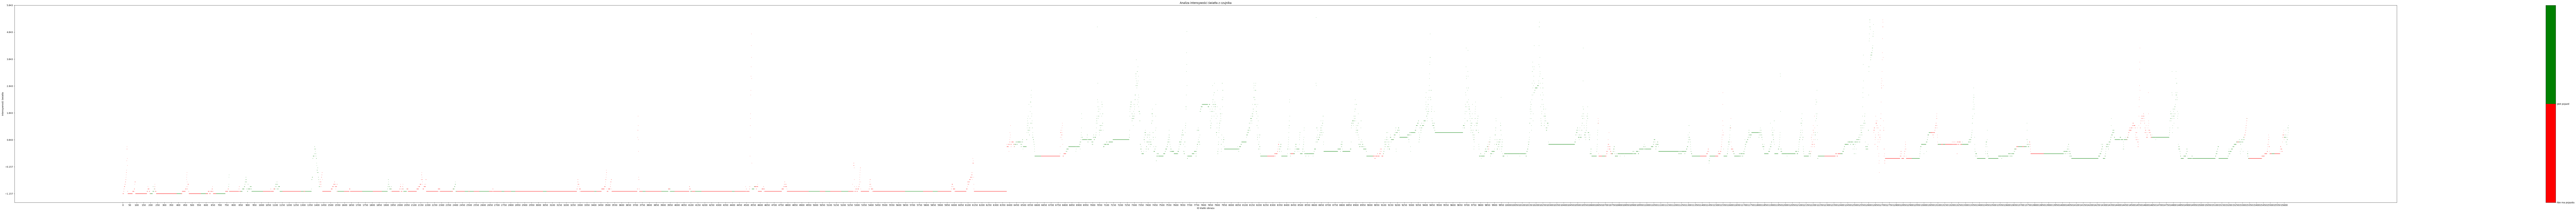

In [63]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib


x = range(len(data_np[:,2]))
y = data_np[:,1].astype(float)
label = data_np[:, 4] == 'True'
colors = ['red','green']

fig = plt.figure(figsize=(240,16))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), s=0.2)

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))

cb.set_ticks(loc)
cb.set_ticklabels(['Nie ma pojazdu', 'Jest pojazd'])

plt.xlabel("ID klatki obrazu")
plt.ylabel("Intensywność światła")
plt.xticks(np.arange(min(x), max(x)+1, 50.0))
plt.yticks(np.arange(min(y), max(y)+1, 1.0))
plt.title('Analiza intensywości światła z czujnika')
plt.show()

['0_109', -1.1573821046220343, 0.0, False, False]


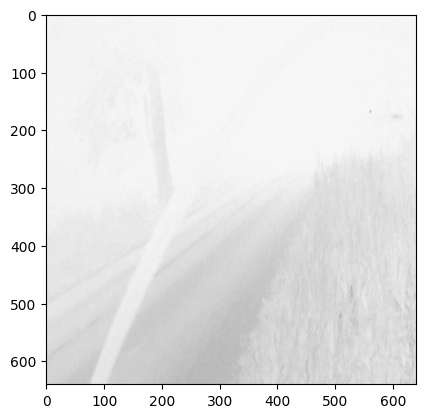

In [64]:
from PIL import Image, ImageOps

for i, x in enumerate(data):
    print(x)
    break
selected_data = data[3480]
filename = f"{selected_data[0]}.jpg"
img = Image.open(f'ground_truth/false/{filename}')
img = ImageOps.invert(img)
plt.imshow(img)


    # ground_truth = data[i][4]

## Definicja modelu

In [38]:
model = Sequential()
# model.add(Dense(25,activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(16, input_shape=(frame_length + 1, 1)))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.build(input_shape=(frame_length + 1, 1))
model.summary()

ValueError: Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (25, 1)

In [32]:
model.fit(X_train_z_score, Y_train, validation_data=(X_test_z_score, Y_test), epochs=30)

Epoch 1/30
12/12 [==============================] - 1s 29ms/step - loss: 0.7118 - binary_accuracy: 0.4626 - precision_10: 1.0000 - recall_10: 0.4626 - val_loss: 1.1756 - val_binary_accuracy: 0.0076 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4840 - binary_accuracy: 0.9224 - precision_10: 1.0000 - recall_10: 0.9224 - val_loss: 1.6047 - val_binary_accuracy: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.3660 - binary_accuracy: 0.9917 - precision_10: 1.0000 - recall_10: 0.9917 - val_loss: 1.9480 - val_binary_accuracy: 0.0000e+00 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2711 - binary_accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - val_loss: 2.2298 - val_binary_accuracy: 0.0000e+00 - val_precision_10:

In [22]:
model2 = Sequential()
model2.add(Conv1D(16, 3, input_shape=(frame_size, 1)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam',
               metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [24]:
model2.fit(X_train_min_max, Y_train, validation_data=(X_test_min_max, Y_test), epochs=3)

Epoch 1/3
12/12 [==============================] - 13s 40ms/step - loss: 0.4042 - binary_accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 1.4299 - val_binary_accuracy: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/3
12/12 [==============================] - 0s 9ms/step - loss: 0.0718 - binary_accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 3.2551 - val_binary_accuracy: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/3
12/12 [==============================] - 0s 8ms/step - loss: 0.0142 - binary_accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 5.1611 - val_binary_accuracy: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
